# Plot ensemble diagnostics of stochastic Ekman-Stokes model

In [1]:
import os
import glob
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
plt.ion()
from scipy import signal, stats 
import torch
from SGESM import SGESM1d

## 1. Comparaison across models

In [29]:
# Set param.
dirm = './data'
config = 'ua5.0_us0.068_hs4.775_ts0'
models = ['p-PDE','p-SPDE']
alphas= [0.2,0.1]
day0 = 10.
outdir = './fig'
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', \
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cl = [colors[0], colors[3]]

# Read data
ds = []
for m in models:
    ncfile = os.path.join(dirm,m,config,'diag.nc')
    ds.append(Dataset(ncfile,'r')) 
t = ds[0].variables['t'][:].data
z = ds[0].variables['z'][:].data
id0 = np.argmin(abs(t - day0))
dys, hrs = int(t[-1]), round(24*(t[-1]-int(t[-1])))
os.makedirs(outdir) if not os.path.isdir(outdir) else None
nm = len(models)

# Define low-pass filter 
dt = t[1] - t[0] # days
fs = 1./dt # samp. freq.
fc = 1. # cutoff freq. (1/days)
wid = fc/(fs/2)
num_filt, denom_filt = signal.butter(5, wid, 'low') # 5th order Butterworth

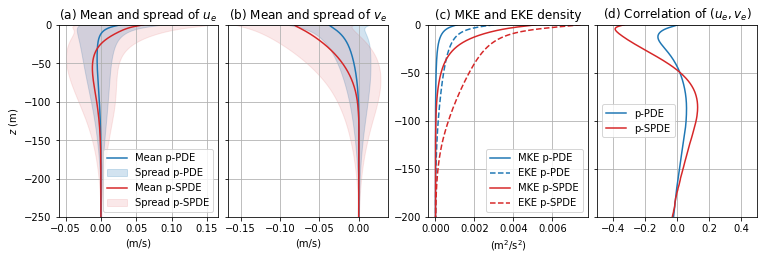

In [30]:
# Mean and CI of Ekman current
fig, ax = plt.subplots(1,4,constrained_layout=True,figsize=(10.5,3.5))
for m in range(nm): 
    um, us = np.mean(ds[m].variables['u_mean'][id0:].data, axis=0), np.mean(ds[m].variables['u_std'][id0:].data, axis=0)    
    ax[0].plot(um[::-1], z[::-1], c=cl[m], label='Mean '+models[m])
    ax[0].fill_betweenx(z[::-1], (um-us)[::-1], (um+us)[::-1], color=cl[m], alpha=alphas[m], label='Spread '+models[m])
    
    um, us = np.mean(ds[m].variables['v_mean'][id0:].data, axis=0), np.mean(ds[m].variables['v_std'][id0:].data, axis=0)    
    ax[1].plot(um[::-1], z[::-1], c=cl[m])
    ax[1].fill_betweenx(z[::-1], (um-us)[::-1], (um+us)[::-1], color=cl[m], alpha=alphas[m])     
    
    ax[2].plot(np.mean(ds[m].variables['mked'][id0:].data, axis=0)[::-1], z[::-1], c=cl[m], label='MKE '+models[m])
    ax[2].plot(np.mean(ds[m].variables['eked'][id0:].data, axis=0)[::-1], z[::-1], c=cl[m], linestyle='dashed', label='EKE '+models[m])
    
    pcc = np.mean(ds[m].variables['uv_cov'][id0:].data / (ds[m].variables['u_std'][id0:].data * \
                  ds[m].variables['v_std'][id0:].data), axis=0)
    ax[3].plot(pcc[::-1], z[::-1], c=cl[m], label=models[m])    

ylim = [-250.,0.]
yt = np.linspace(ylim[0],ylim[1],6,endpoint=True)    
ax[0].set(title='(a) Mean and spread of $u_e$', xlabel='(m/s)', ylabel='$z$ (m)', ylim=ylim, yticks=yt)
ax[0].grid()
ax[0].legend(loc='lower right')
ax[1].set(title='(b) Mean and spread of $v_e$', xlabel='(m/s)', yticklabels=[], ylim=ylim, yticks=yt)
ax[1].grid()
ylim = [-200.,0.]
yt = np.linspace(ylim[0],ylim[1],5,endpoint=True)
ax[2].set(title='(c) MKE and EKE density', xlabel=r'(m$^2$/s$^2$)', ylim=ylim, yticks=yt)
ax[2].grid()
ax[2].legend(loc='lower right')
ax[3].set(title='(d) Correlation of ($u_e,v_e$)', yticklabels=[], xlim=[-.5,.5], ylim=ylim, yticks=yt)
ax[3].grid()
ax[3].legend(loc='center left')

output = os.path.join(outdir,'uv_mean_std_models.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

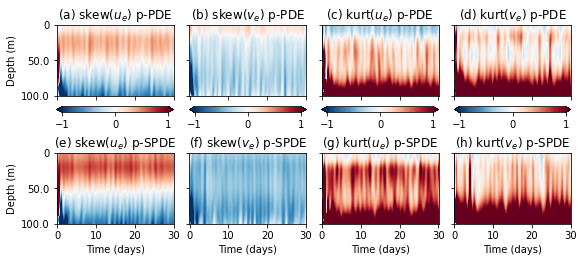

In [31]:
# Skewness and kurtosis of Ekman current
def int_to_lt(n):
    # Convert integer to ASCII code for 'a' (97) and subtract 1 to map 1 to 'a'
    return chr(n + 97)

var = ['u_skew','v_skew','u_kurt','v_kurt']
nam = ['skew($u_e$)','skew($v_e$)','kurt($u_e$)','kurt($v_e$)']
hmax = 100.
iz = np.argmin(abs(z + hmax))
xt = np.arange(0,len(t),len(t)//3)
xtl = t[xt].astype(int)
yt = [0,len(z[:iz])//2,len(z[:iz])]
ytl = [0,hmax/2,hmax]
vmin, vmax = -1, 1
ticks = np.linspace(vmin, vmax, 3, endpoint=True)

fig, ax = plt.subplots(len(ds),len(var),sharex=True,sharey=True,constrained_layout=True,figsize=(8,3.5))
kwargs = {'cmap':'RdBu_r', 'vmin':vmin, 'vmax':vmax}
n = 0
for i in range(nm):
    for j in range(len(var)):
        f = signal.filtfilt(num_filt, denom_filt, ds[i].variables[var[j]][:,:iz].data, axis=0)
        im = ax[i,j].imshow(f.T, **kwargs)
        ax[i,j].set_title(f'({int_to_lt(n)}) {nam[j]} {models[i]}')
        n += 1
        if i == (nm-1):
            ax[i,j].set(xlabel='Time (days)', xticks=xt, xticklabels=xtl)
        if i == 0:            
            plt.colorbar(im, ax=ax[i,j], ticks=ticks, orientation='horizontal', extend='both', fraction=0.07)
    ax[i,0].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')            
output = os.path.join(outdir,'uv_skew_kurt_models.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

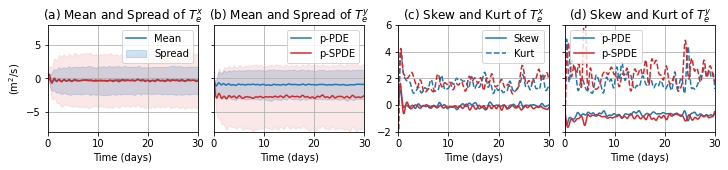

In [32]:
fig, ax = plt.subplots(1,4,sharex=True,constrained_layout=True,figsize=(10,2.25))
for m in range(nm):
    fmean = signal.filtfilt(num_filt, denom_filt, ds[m].variables['Tx_mean'][:].data)
    fstd = signal.filtfilt(num_filt, denom_filt, ds[m].variables['Tx_std'][:].data)
    if m==0:
        ax[0].plot(t, fmean, c=cl[m], label='Mean')
        ax[0].fill_between(t, fmean-fstd, fmean+fstd, color=cl[m], alpha=alphas[m], label='Spread')
    else:
        ax[0].plot(t, fmean, c=cl[m])
        ax[0].fill_between(t, fmean-fstd, fmean+fstd, color=cl[m], alpha=alphas[m])
    fmean = signal.filtfilt(num_filt, denom_filt, ds[m].variables['Ty_mean'][:].data)
    fstd = signal.filtfilt(num_filt, denom_filt, ds[m].variables['Ty_std'][:].data)    
    ax[1].plot(t, fmean, c=cl[m], label=models[m])
    ax[1].fill_between(t, fmean-fstd, fmean+fstd, color=cl[m], alpha=alphas[m])    

    fskew = signal.filtfilt(num_filt, denom_filt, ds[m].variables['Tx_skew'][:].data)
    fkurt = signal.filtfilt(num_filt, denom_filt, ds[m].variables['Tx_kurt'][:].data)
    if m==0:
        ax[2].plot(t, fskew, c=cl[m], label='Skew')
        ax[2].plot(t, fkurt, c=cl[m], linestyle='dashed', label='Kurt')
    else:
        ax[2].plot(t, fskew, c=cl[m])
        ax[2].plot(t, fkurt, c=cl[m], linestyle='dashed')        
    
    fskew = signal.filtfilt(num_filt, denom_filt, ds[m].variables['Ty_skew'][:].data)
    fkurt = signal.filtfilt(num_filt, denom_filt, ds[m].variables['Ty_kurt'][:].data)
    ax[3].plot(t, fskew, c=cl[m], label=models[m])
    ax[3].plot(t, fkurt, c=cl[m], linestyle='dashed')    
    
xlim = [t[0],t[-1]]
ylim = [-8,8]    
ax[0].set(title='(a) Mean and Spread of $T_e^x$', ylim=ylim, ylabel='(m$^2$/s)')    
ax[1].set(title='(b) Mean and Spread of $T_e^y$', ylim=ylim, yticklabels=[]) 
ylim = [-2,6]
ax[2].set(title='(c) Skew and Kurt of $T_e^x$', ylim=ylim)    
ax[3].set(title='(d) Skew and Kurt of $T_e^y$', ylim=ylim, yticklabels=[])
for c in range(4):
    ax[c].set(xlim=xlim, xlabel='Time (days)')
    ax[c].legend(loc='best')
    ax[c].grid(True)    
    
output = os.path.join(outdir,'time_series_models.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

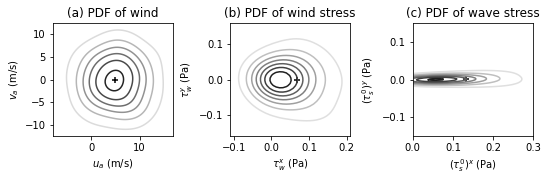

In [33]:
# Plot PDFs of wind and wave
def kde_pdf(U):
    u, v = U.real.copy(), U.imag.copy()
    xmin, xmax = u.min(), u.max()
    ymin, ymax = v.min(), v.max()
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    pos = np.vstack([X.ravel(), Y.ravel()])
    val = np.vstack([u, v])
    kerl = stats.gaussian_kde(val, bw_method=0.5)
    Z = kerl(pos).T.reshape(X.shape)
    return X, Y, Z
    
fig, ax = plt.subplots(1,3,constrained_layout=True,figsize=(7.5,2.4))
U = ds[-1].variables['ua_end'][:].data + 1j*ds[-1].variables['va_end'][:].data
X, Y, Z = kde_pdf(U)
ax[0].contour(X, Y, Z, cmap='binary')
Xm, Ym = U.real.mean(), U.imag.mean()
ax[0].scatter(Xm, Ym, s=40, marker='+', c='k')
xmin, ymin, lxy = -8, -12.5, 25
xl, yl = [xmin,xmin+lxy], [ymin,ymin+lxy]
ax[0].set(title='(a) PDF of wind', xlabel='$u_a$ (m/s)', ylabel='$v_a$ (m/s)', xlim=xl, ylim=yl)

U = ds[-1].variables['twx_end'][:].data + 1j*ds[-1].variables['twy_end'][:].data
X, Y, Z = kde_pdf(U)
ax[1].contour(X, Y, Z, cmap='binary')
Xm, Ym = U.real.mean(), U.imag.mean()
ax[1].scatter(Xm, Ym, s=40, marker='+', c='k')
xmin, ymin, lxy = -0.11, -0.16, 0.32
xl, yl = [xmin,xmin+lxy], [ymin,ymin+lxy]
ax[1].set(title='(b) PDF of wind stress', xlabel=r'$\tau_w^x$ (Pa)', ylabel=r'$\tau_w^y$ (Pa)', xlim=xl, ylim=yl)

U = ds[-1].variables['tsx_end'][:].data + 1j*ds[-1].variables['tsy_end'][:].data
X, Y, Z = kde_pdf(U)
ax[2].contour(X, Y, Z, cmap='binary')
Xm, Ym = U.real.mean(), U.imag.mean()
ax[2].scatter(Xm, Ym, s=40, marker='+', c='k')
xmin, ymin, lxy = 0, -0.15, 0.3
xl, yl = [xmin,xmin+lxy], [ymin,ymin+lxy]
ax[2].set(title='(c) PDF of wave stress', xlabel=r'$(\tau_s^0)^x$ (Pa)', ylabel=r'$(\tau_s^0)^y$ (Pa)', xlim=xl, ylim=yl)

output = os.path.join(outdir,'pdf_params.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

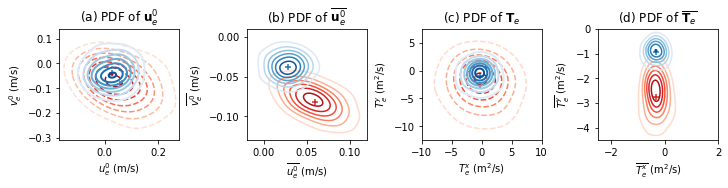

In [109]:
fig, ax = plt.subplots(1,4,constrained_layout=True,figsize=(10,2.5))
cm = ['Blues','Reds']
xmin, ymin, lxy = -10, -12.5, 20
xl_T, yl_T = [xmin,xmin+lxy], [ymin,ymin+lxy]
xmin, ymin, lxy = -0.17, -0.31, 0.45
xl_u0, yl_u0 = [xmin,xmin+lxy], [ymin,ymin+lxy]
xmin, ymin, lxy = -2.5, -4.5, 4.5
xl_Tm, yl_Tm = [xmin,xmin+lxy], [ymin,ymin+lxy]
xmin, ymin, lxy = -0.02, -0.13, 0.14
xl_u0m, yl_u0m = [xmin,xmin+lxy], [ymin,ymin+lxy]

for m in range(nm): 
    m = nm-1-m
    U = ds[m].variables['u0_end'][:].data + 1j*ds[m].variables['v0_end'][:].data
    X, Y, Z = kde_pdf(U)  
    if m==0:
        ax[0].contour(X, Y, Z, cmap=cm[m], linewidths=2)
    else:
        ax[0].contour(X, Y, Z, cmap=cm[m], linestyles='dashed')
    Xm, Ym = U.real.mean(), U.imag.mean()    
    ax[0].scatter(Xm, Ym, marker='+', c=cl[m])
    ax[0].set(title='(a) PDF of $\mathbf{u}_e^0$', xlabel='$u_e^0$ (m/s)', \
              ylabel='$v_e^0$ (m/s)', xlim=xl_u0, ylim=yl_u0) 
    
    U = ds[m].variables['u0_tmean'][:].data + 1j*ds[m].variables['v0_tmean'][:].data
    X, Y, Z = kde_pdf(U)  
    ax[1].contour(X, Y, Z, cmap=cm[m])
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[1].scatter(Xm, Ym, marker='+', c=cl[m])
    ax[1].set(title='(b) PDF of $\overline{\mathbf{u}_e^0}$', xlabel='$\overline{u_e^0}$ (m/s)', \
              ylabel='$\overline{v_e^0}$ (m/s)', xlim=xl_u0m, ylim=yl_u0m)        
    
    U = ds[m].variables['Tx_end'][:].data + 1j*ds[m].variables['Ty_end'][:].data
    X, Y, Z = kde_pdf(U)
    if m==0:
        ax[2].contour(X, Y, Z, cmap=cm[m], linewidths=2)
    else:
        ax[2].contour(X, Y, Z, cmap=cm[m], linestyles='dashed')
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[2].scatter(Xm, Ym, marker='+', c=cl[m])
    ax[2].set(title='(c) PDF of $\mathbf{T}_e$', xlabel='$T_e^x$ (m$^2$/s)', \
              ylabel='$T_e^y$ (m$^2$/s)', xlim=xl_T, ylim=yl_T)     

    U = ds[m].variables['Tx_tmean'][:].data + 1j*ds[m].variables['Ty_tmean'][:].data
    X, Y, Z = kde_pdf(U)
    ax[3].contour(X, Y, Z, cmap=cm[m])
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[3].scatter(Xm, Ym, marker='+', c=cl[m])
    ax[3].set(title='(d) PDF of $\overline{\mathbf{T}_e}$', xlabel='$\overline{T_e^x}$ (m$^2$/s)', \
              ylabel='$\overline{T_e^y}$ (m$^2$/s)', xlim=xl_Tm, ylim=yl_Tm)
    
output = os.path.join(outdir,'pdf_models.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)    

### 2. Comparison across transient wind levels

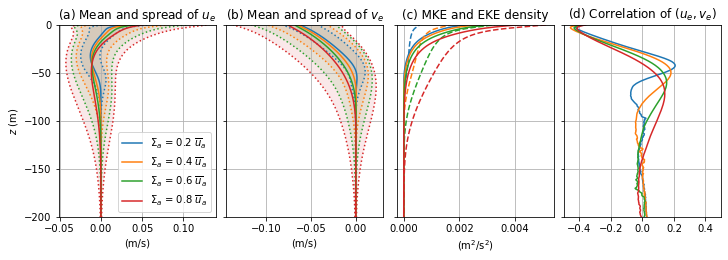

In [8]:
# Reset param.
dirm = './data/p-SPDE'
ua_std = [1,2,3,4]
#ua_std = [0.5,1.5,3,4.5]
ua_mean = 5.
us0 = 0.068
hs = 4.775
theta_mean = 0
nm = len(ua_std)

# Read data
ds = []
labels = []
for m in range(nm):
    ncfile = os.path.join(dirm,f'ua{ua_std[m]:.1f}_us{us0:.3f}_hs{hs:.3f}_ts{theta_mean}','diag.nc')
    ds.append(Dataset(ncfile,'r')) 
    labels.append(r'$\Sigma_a $ = ' + f'{ua_std[m]/ua_mean:.1f} ' + r'$\overline{u}_a$')
t = ds[0].variables['t'][:].data
z = ds[0].variables['z'][:].data
id0 = np.argmin(abs(t - day0))

# Plot in depth
fig, ax = plt.subplots(1,4,sharey=True,constrained_layout=True,figsize=(10,3.5))
ylim = [-200.,0.]
yt = np.linspace(ylim[0],ylim[1],5,endpoint=True)
for m in range(nm): 
    um, us = np.mean(ds[m].variables['u_mean'][id0:].data, axis=0), np.mean(ds[m].variables['u_std'][id0:].data, axis=0)
    ax[0].plot(um[::-1], z[::-1], label=labels[m])
    ax[0].fill_betweenx(z[::-1], (um-us)[::-1], (um+us)[::-1], alpha=0.1)
    ax[0].plot((um-us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    ax[0].plot((um+us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    
    um, us = np.mean(ds[m].variables['v_mean'][id0:].data, axis=0), np.mean(ds[m].variables['v_std'][id0:].data, axis=0)
    ax[1].plot(um[::-1], z[::-1], label=labels[m])
    ax[1].fill_betweenx(z[::-1], (um-us)[::-1], (um+us)[::-1], alpha=0.1)     
    ax[1].plot((um-us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    ax[1].plot((um+us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    
    ax[2].plot(np.mean(ds[m].variables['mked'][id0:].data, axis=0)[::-1], z[::-1], label=labels[m])
    ax[2].plot(np.mean(ds[m].variables['eked'][id0:].data, axis=0)[::-1], z[::-1], c=colors[m], linestyle='dashed')
    
    pcc = np.mean(ds[m].variables['uv_cov'][id0:].data / (ds[m].variables['u_std'][id0:].data * \
                  ds[m].variables['v_std'][id0:].data), axis=0)
    ax[3].plot(pcc[::-1], z[::-1], c=colors[m], label=labels[m]) 
    
ax[0].set(title='(a) Mean and spread of $u_e$', xlabel='(m/s)', ylabel='$z$ (m)', ylim=ylim, yticks=yt)
ax[0].grid()
ax[0].legend(loc='lower right')
ax[1].set(title='(b) Mean and spread of $v_e$', xlabel='(m/s)')
ax[1].grid()
ax[2].set(title='(c) MKE and EKE density', xlabel=r'(m$^2$/s$^2$)')
ax[2].grid()
ax[3].set(title='(d) Correlation of ($u_e,v_e$)', xlim=[-.5,.5])
ax[3].grid()

output = os.path.join(outdir,'uv_mean_std_uastd.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

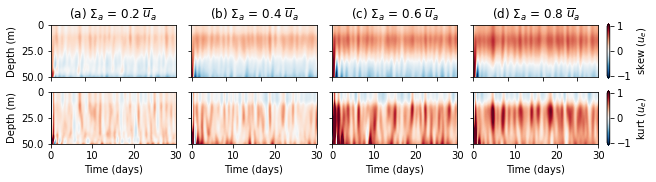

In [9]:
# Skewness and kurtosis of u
fig, ax = plt.subplots(2,len(ds),constrained_layout=True,figsize=(9,2.4))
hmax = 50.
iz = np.argmin(abs(z + hmax))
xt = np.arange(0,len(t),len(t)//3)
xtl = t[xt].astype(int)
yt = [0,len(z[:iz])//2,len(z[:iz])]
ytl = [0,hmax/2,hmax]
vmin, vmax = -1, 1
ticks = np.linspace(vmin, vmax, 3, endpoint=True)
tit = []
for m in range(nm):
    tit.append(f'({int_to_lt(m)}) {labels[m]}')

for m in range(nm):
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['u_skew'][:,:iz].data, axis=0)
    im = ax[0,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[0,m].set(title=tit[m], xticklabels=[])
    if m > 0:
        ax[0,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[0,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')    
cb = plt.colorbar(im, ax=ax[0,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('skew ($u_e$)')

for m in range(nm):
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['u_kurt'][:,:iz].data, axis=0)
    im = ax[1,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[1,m].set(xlabel='Time (days)', xticks=xt, xticklabels=xtl)  
    if m > 0:
        ax[1,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[1,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')     
cb = plt.colorbar(im, ax=ax[1,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('kurt ($u_e$)')

output = os.path.join(outdir,'u_skew_kurt_uastd.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

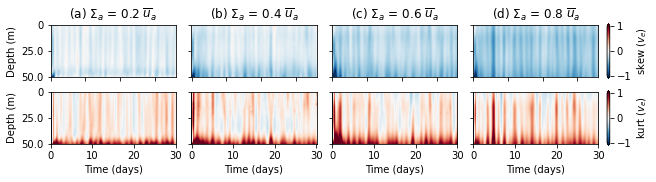

In [10]:
# Skewness and kurtosis of v
fig, ax = plt.subplots(2,len(ds),constrained_layout=True,figsize=(9,2.4))
for m in range(nm):
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['v_skew'][:,:iz].data, axis=0)
    im = ax[0,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[0,m].set(title=tit[m], xticklabels=[])
    if m > 0:
        ax[0,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[0,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')    
cb = plt.colorbar(im, ax=ax[0,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('skew ($v_e$)')

for m in range(nm):
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['v_kurt'][:,:iz].data, axis=0)
    im = ax[1,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[1,m].set(xlabel='Time (days)', xticks=xt, xticklabels=xtl)  
    if m > 0:
        ax[1,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[1,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')     
cb = plt.colorbar(im, ax=ax[1,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('kurt ($v_e$)')

output = os.path.join(outdir,'v_skew_kurt_uastd.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

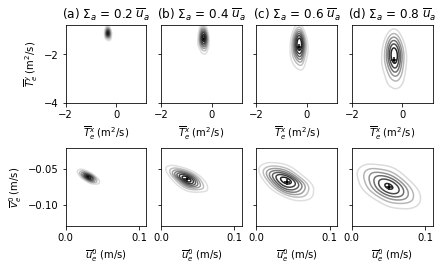

In [11]:
# Plot PDFs of Ekman transport and surface current
fig, ax = plt.subplots(2,nm,sharex='row',sharey='row',constrained_layout=True,figsize=(6,3.65))
xmin, ymin, lxy = -2, -4, 3.2
xl_T, yl_T = [xmin,xmin+lxy], [ymin,ymin+lxy]
xmin, ymin, lxy = 0, -0.13, 0.11
xl_u0, yl_u0 = [xmin,xmin+lxy], [ymin,ymin+lxy]

for m in range(nm):
    U = ds[m].variables['Tx_tmean'][:].data + 1j*ds[m].variables['Ty_tmean'][:].data
    X, Y, Z = kde_pdf(U)
    ax[0,m].contour(X, Y, Z, cmap='binary')
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[0,m].scatter(Xm, Ym, marker='+', c='k')
    ax[0,m].set(title=tit[m], xlabel='$\overline{T}_e^x$ (m$^2$/s)', xlim=xl_T, ylim=yl_T)
    
    U = ds[m].variables['u0_tmean'][:].data + 1j*ds[m].variables['v0_tmean'][:].data
    X, Y, Z = kde_pdf(U)
    ax[1,m].contour(X, Y, Z, cmap='binary')
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[1,m].scatter(Xm, Ym, marker='+', c='k')    
    ax[1,m].set(xlabel='$\overline{u}_e^0$ (m/s)', xlim=xl_u0, ylim=yl_u0)    
ax[0,0].set_ylabel('$\overline{T}_e^y$ (m$^2$/s)')  
ax[1,0].set_ylabel('$\overline{v}_e^0$ (m/s)')   

output = os.path.join(outdir,'pdf_uastd.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

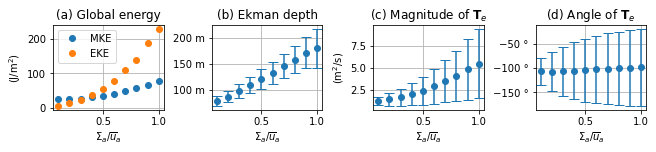

In [12]:
# Scatter plot of diagnostic variables
nm = 10
ratio = np.linspace(0.1,1.0,nm)
ds = []
for m in range(nm):
    ncfile = os.path.join(dirm,f'ua{ua_mean*ratio[m]:.1f}_us{us0:.3f}_hs{hs:.3f}_ts{theta_mean}','diag.nc')
    ds.append(Dataset(ncfile,'r')) 

mke, eke = [], []
h_mean, h_std = [], []
T_mean, T_std = [], []
arg_mean, arg_std = [], []
for m in range(nm):
    mke.append(np.mean(ds[m].variables['mke'][id0:].data))
    eke.append(np.mean(ds[m].variables['eke'][id0:].data))
    
    h_mean.append(np.mean(ds[m].variables['h_mean'][id0:].data))
    h_std.append(np.mean(ds[m].variables['h_std'][id0:].data))
    
    Tm = np.mean(ds[m].variables['absT_mean'][id0:].data)
    Ts = np.mean(ds[m].variables['absT_std'][id0:].data)
    #T = ds[m].variables['Tx_tmean'][:].data + 1j*ds[m].variables['Ty_tmean'][:].data
    #Tm, Ts = np.mean(abs(T)), np.std(abs(T))
    T_mean.append(Tm)
    T_std.append(Ts)
    
    argm = stats.circmean(ds[m].variables['argT_mean'][id0:].data) - 2*np.pi
    args = stats.circmean(ds[m].variables['argT_std'][id0:].data)    
    #arg = np.angle(T)
    #argm, args = stats.circmean(arg)-2*np.pi, stats.circstd(arg)
    arg_mean.append(np.rad2deg(argm))
    arg_std.append(np.rad2deg(args))
    
fig, ax = plt.subplots(1,4,constrained_layout=True,figsize=(9,2))    
ax[0].errorbar(ratio, mke, fmt='o', label='MKE') 
ax[0].errorbar(ratio, eke, fmt='o', label='EKE') 
ax[0].set(xlabel=r'$\Sigma_a / \overline{u}_a$', ylabel='(J/m$^2$)', title='(a) Global energy')
ax[0].legend()
ax[0].grid()    
    
ax[1].errorbar(ratio, h_mean, h_std, fmt='o', capsize=5)    
ax[1].set(xlabel=r'$\Sigma_a / \overline{u}_a$', title='(b) Ekman depth')
ax[1].yaxis.set_major_formatter(EngFormatter(unit=u"m"))
ax[1].grid()

ax[2].errorbar(ratio, T_mean, T_std, fmt='o', capsize=5)    
ax[2].set(xlabel=r'$\Sigma_a / \overline{u}_a$', ylabel='(m$^2$/s)', title='(c) Magnitude of $\mathbf{T}_e$')
ax[2].grid()

ax[3].errorbar(ratio, arg_mean, arg_std, fmt='o', capsize=5)    
ax[3].set(xlabel=r'$\Sigma_a / \overline{u}_a$', title='(d) Angle of $\mathbf{T}_e$')
ax[3].yaxis.set_major_formatter(EngFormatter(unit=u"°"))
ax[3].grid()    
    
output = os.path.join(outdir,'errbar_uastd.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

### 3. Comparison across wavenumbers

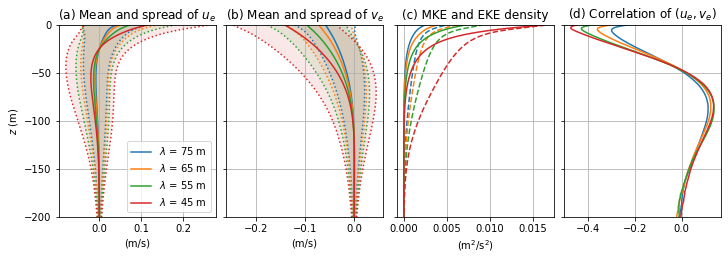

In [13]:
# Update param.
ua_std = 5.0
lambdas = [75, 65, 55, 45]
eta0 = 0.8
g = 9.81
nm = len(lambdas)

# Read data
ds = []
labels = []
for m in range(nm):
    k = 2*np.pi/lambdas[m]
    ncfile = os.path.join(dirm,f'ua{ua_std}_us{np.sqrt(g*k)*k*eta0**2:.3f}_hs{0.5/k:.3f}_ts{theta_mean}','diag.nc')
    ds.append(Dataset(ncfile,'r')) 
    labels.append(fr'$\lambda$ = {lambdas[m]} m')
t = ds[0].variables['t'][:].data
z = ds[0].variables['z'][:].data
id0 = np.argmin(abs(t - day0))

# Plot in depth
fig, ax = plt.subplots(1,4,sharey=True,constrained_layout=True,figsize=(10,3.5))
ylim = [-200.,0.]
yt = np.linspace(ylim[0],ylim[1],5,endpoint=True)
for m in range(nm): 
    um, us = np.mean(ds[m].variables['u_mean'][id0:].data, axis=0), np.mean(ds[m].variables['u_std'][id0:].data, axis=0)
    ax[0].plot(um[::-1], z[::-1], label=labels[m])
    ax[0].fill_betweenx(z[::-1], (um-us)[::-1], (um+us)[::-1], alpha=0.1)
    ax[0].plot((um-us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    ax[0].plot((um+us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    
    um, us = np.mean(ds[m].variables['v_mean'][id0:].data, axis=0), np.mean(ds[m].variables['v_std'][id0:].data, axis=0)
    ax[1].plot(um[::-1], z[::-1], label=labels[m])
    ax[1].fill_betweenx(z[::-1], (um-us)[::-1], (um+us)[::-1], alpha=0.1)     
    ax[1].plot((um-us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    ax[1].plot((um+us)[::-1], z[::-1], c=colors[m], linestyle='dotted') 
    
    ax[2].plot(np.mean(ds[m].variables['mked'][id0:].data, axis=0)[::-1], z[::-1], label=labels[m])
    ax[2].plot(np.mean(ds[m].variables['eked'][id0:].data, axis=0)[::-1], z[::-1], c=colors[m], linestyle='dashed')
    
    pcc = np.mean(ds[m].variables['uv_cov'][id0:].data / (ds[m].variables['u_std'][id0:].data * \
                  ds[m].variables['v_std'][id0:].data), axis=0)
    ax[3].plot(pcc[::-1], z[::-1])
    
ax[0].set(title='(a) Mean and spread of $u_e$', xlabel='(m/s)', ylabel='$z$ (m)', ylim=ylim, yticks=yt)
ax[0].grid()
ax[0].legend(loc='lower right')
ax[1].set(title='(b) Mean and spread of $v_e$', xlabel='(m/s)')
ax[1].grid()
ax[2].set(title='(c) MKE and EKE density', xlabel='(m$^2$/s$^2$)')
ax[2].grid()
ax[3].set(title='(d) Correlation of ($u_e,v_e$)')
ax[3].grid()

output = os.path.join(outdir,'uv_mean_std_lambdas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

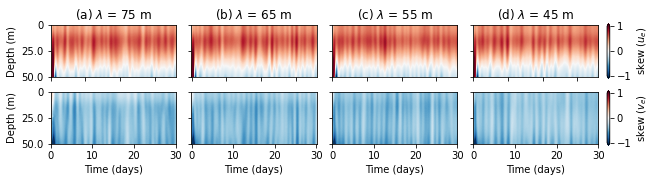

In [14]:
# Skewness of Ekman current
hmax = 50.
iz = np.argmin(abs(z + hmax))
xt = np.arange(0,len(t),len(t)//3)
xtl = t[xt].astype(int)
yt = [0,len(z[:iz])//2,len(z[:iz])]
ytl = [0,hmax/2,hmax]
vmin, vmax = -1, 1
ticks = np.linspace(vmin, vmax, 3, endpoint=True)
tit = []
for m in range(nm):
    tit.append(f'({int_to_lt(m)}) {labels[m]}')

fig, ax = plt.subplots(2,len(ds),constrained_layout=True,figsize=(9,2.4))
for m in range(nm):
    #im = ax[0,m].imshow(ds[m].variables['u_skew'][:,:iz].data.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['u_skew'][:,:iz].data, axis=0)
    im = ax[0,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[0,m].set(title=tit[m], xticklabels=[])
    if m > 0:
        ax[0,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[0,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')    
cb = plt.colorbar(im, ax=ax[0,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('skew ($u_e$)')

for m in range(nm):
    #im = ax[1,m].imshow(ds[m].variables['v_skew'][:,:iz].data.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['v_skew'][:,:iz].data, axis=0)
    im = ax[1,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[1,m].set(xlabel='Time (days)', xticks=xt, xticklabels=xtl)  
    if m > 0:
        ax[1,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[1,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')     
cb = plt.colorbar(im, ax=ax[1,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('skew ($v_e$)')

output = os.path.join(outdir,'uv_skew_lambdas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

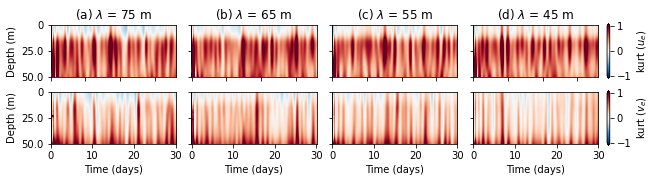

In [15]:
# Kurtosis of Ekman current

fig, ax = plt.subplots(2,len(ds),constrained_layout=True,figsize=(9,2.4))
for m in range(nm):
    #im = ax[0,m].imshow(ds[m].variables['u_kurt'][:,:iz].data.T, cmap='RdBu_r', vmin=-1, vmax=1)
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['u_kurt'][:,:iz].data, axis=0)
    im = ax[0,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[0,m].set(title=tit[m], xticklabels=[])
    if m > 0:
        ax[0,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[0,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')    
cb = plt.colorbar(im, ax=ax[0,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('kurt ($u_e$)')

for m in range(nm):
    #im = ax[1,m].imshow(ds[m].variables['v_kurt'][:,:iz].data.T, cmap='RdBu_r', vmin=-1, vmax=1)
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['v_kurt'][:,:iz].data, axis=0)
    im = ax[1,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[1,m].set(xlabel='Time (days)', xticks=xt, xticklabels=xtl)  
    if m > 0:
        ax[1,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[1,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')     
cb = plt.colorbar(im, ax=ax[1,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('kurt ($v_e$)')

output = os.path.join(outdir,'uv_kurt_lambdas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

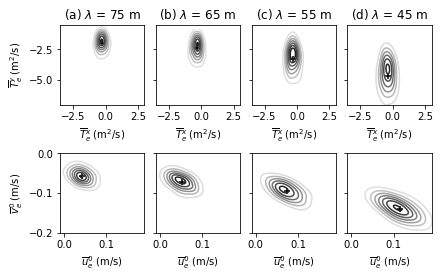

In [16]:
# Plot PDFs of Ekman transport and surface current
xmin, ymin, lxy = -3.5, -7, 6.5
xl_T, yl_T = [xmin,xmin+lxy], [ymin,ymin+lxy]
xmin, ymin, lxy = -0.01, -0.2, 0.2
xl_u0, yl_u0 = [xmin,xmin+lxy], [ymin,ymin+lxy]

fig, ax = plt.subplots(2,nm,sharex='row',sharey='row',constrained_layout=True,figsize=(6,3.75))
for m in range(nm):
    U = ds[m].variables['Tx_tmean'][:].data + 1j*ds[m].variables['Ty_tmean'][:].data
    X, Y, Z = kde_pdf(U)
    ax[0,m].contour(X, Y, Z, cmap='binary')
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[0,m].scatter(Xm, Ym, marker='+', c='k')
    ax[0,m].set(title=tit[m], xlabel='$\overline{T}_e^x$ (m$^2$/s)', xlim=xl_T, ylim=yl_T)
    
    U = ds[m].variables['u0_tmean'][:].data + 1j*ds[m].variables['v0_tmean'][:].data
    X, Y, Z = kde_pdf(U)
    ax[1,m].contour(X, Y, Z, cmap='binary')
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[1,m].scatter(Xm, Ym, marker='+', c='k')    
    ax[1,m].set(xlabel='$\overline{u}_e^0$ (m/s)', xlim=xl_u0, ylim=yl_u0)    
ax[0,0].set_ylabel('$\overline{T}_e^y$ (m$^2$/s)')  
ax[1,0].set_ylabel('$\overline{v}_e^0$ (m/s)')   

output = os.path.join(outdir,'pdf_lambdas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

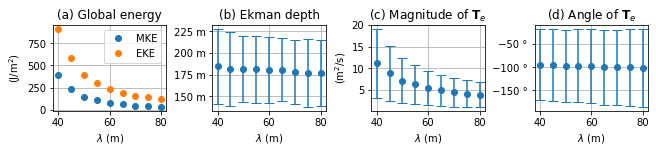

In [17]:
# Scatter plot
nm = 9
lambdas = np.linspace(80,40,nm)
ds = []
for m in range(nm):
    k = 2*np.pi/lambdas[m]
    ncfile = os.path.join(dirm,f'ua{ua_std}_us{np.sqrt(g*k)*k*eta0**2:.3f}_hs{0.5/k:.3f}_ts{theta_mean}','diag.nc')
    ds.append(Dataset(ncfile,'r')) 
    
mke, eke = [], []
h_mean, h_std = [], []
T_mean, T_std = [], []
arg_mean, arg_std = [], []
for m in range(nm):
    mke.append(np.mean(ds[m].variables['mke'][id0:].data))
    eke.append(np.mean(ds[m].variables['eke'][id0:].data))
    
    h_mean.append(np.mean(ds[m].variables['h_mean'][id0:].data))
    h_std.append(np.mean(ds[m].variables['h_std'][id0:].data))
    
    Tm = np.mean(ds[m].variables['absT_mean'][id0:].data)
    Ts = np.mean(ds[m].variables['absT_std'][id0:].data)
    #T = ds[m].variables['Tx_tmean'][:].data + 1j*ds[m].variables['Ty_tmean'][:].data
    #Tm, Ts = np.mean(abs(T)), np.std(abs(T))
    T_mean.append(Tm)
    T_std.append(Ts)
    
    argm = stats.circmean(ds[m].variables['argT_mean'][id0:].data) - 2*np.pi
    args = stats.circmean(ds[m].variables['argT_std'][id0:].data)
    #arg = np.angle(T)
    #argm, args = stats.circmean(arg)-2*np.pi, stats.circstd(arg)
    arg_mean.append(np.rad2deg(argm))
    arg_std.append(np.rad2deg(args))

fig, ax = plt.subplots(1,4,constrained_layout=True,figsize=(9,2))    
ax[0].errorbar(lambdas, mke, fmt='o', label='MKE') 
ax[0].errorbar(lambdas, eke, fmt='o', label='EKE') 
ax[0].set(xlabel=r'$\lambda$ (m)', ylabel='(J/m$^2$)', title='(a) Global energy')
ax[0].legend()
ax[0].grid()    
    
ax[1].errorbar(lambdas, h_mean, h_std, fmt='o', capsize=5)    
ax[1].set(xlabel=r'$\lambda$ (m)', title='(b) Ekman depth')
ax[1].yaxis.set_major_formatter(EngFormatter(unit=u"m"))
ax[1].grid()

ax[2].errorbar(lambdas, T_mean, T_std, fmt='o', capsize=5)    
ax[2].set(xlabel=r'$\lambda$ (m)', ylabel='(m$^2$/s)', title='(c) Magnitude of $\mathbf{T}_e$')
ax[2].grid()

ax[3].errorbar(lambdas, arg_mean, arg_std, fmt='o', capsize=5)    
ax[3].set(xlabel=r'$\lambda$ (m)', title='(d) Angle of $\mathbf{T}_e$')
ax[3].yaxis.set_major_formatter(EngFormatter(unit=u"°"))
ax[3].grid() 
     
output = os.path.join(outdir,'errbar_lambdas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

### 4. Comparison across wave mean angles

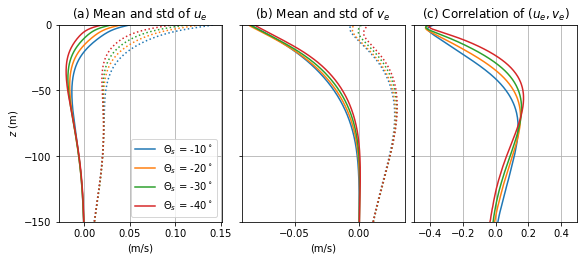

In [27]:
# Update param.
theta_mean = [-10,-20,-30,-40]
hs = 4.775
us0 = 0.068
ua_std = 5

# Read data
ds = []
labels = []
for m in theta_mean:
    ncfile = os.path.join(dirm,f'ua{ua_std:.1f}_us{us0:.3f}_hs{hs:.3f}_ts{m}','diag.nc')
    ds.append(Dataset(ncfile,'r')) 
    labels.append(fr'$\Theta_s$ = {m}$^\circ$')
t = ds[0].variables['t'][:].data
z = ds[0].variables['z'][:].data
id0 = np.argmin(abs(t - day0))
nm = len(ds)

# Plot in depth
fig, ax = plt.subplots(1,3,sharey=True,constrained_layout=True,figsize=(8,3.5))
ylim = [-150.,0.]
yt = np.linspace(ylim[0],ylim[1],4,endpoint=True)
for m in range(nm): 
    um, us = np.mean(ds[m].variables['u_mean'][id0:].data, axis=0), np.mean(ds[m].variables['u_std'][id0:].data, axis=0)
    ax[0].plot(um[::-1], z[::-1], label=labels[m])
    ax[0].plot((um+us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    
    um, us = np.mean(ds[m].variables['v_mean'][id0:].data, axis=0), np.mean(ds[m].variables['v_std'][id0:].data, axis=0)
    ax[1].plot(um[::-1], z[::-1], label=labels[m])
    ax[1].plot((um+us)[::-1], z[::-1], c=colors[m], linestyle='dotted')
    
    #ax[2].plot(np.mean(ds[m].variables['mked'][id0:].data, axis=0)[::-1], z[::-1], label=labels[m])
    #ax[2].plot(np.mean(ds[m].variables['eked'][id0:].data, axis=0)[::-1], z[::-1], c=colors[m], linestyle='dashed')
    
    pcc = np.mean(ds[m].variables['uv_cov'][id0:].data / (ds[m].variables['u_std'][id0:].data * \
                  ds[m].variables['v_std'][id0:].data), axis=0)
    ax[2].plot(pcc[::-1], z[::-1], label=labels[m])    
    
ax[0].set(title='(a) Mean and std of $u_e$', xlabel='(m/s)', ylabel='$z$ (m)', ylim=ylim, yticks=yt)
ax[0].grid()
ax[0].legend(loc='lower right')
ax[1].set(title='(b) Mean and std of $v_e$', xlabel='(m/s)')
ax[1].grid()
#ax[2].set(title='(c) MKE and EKE density', xlabel='(m$^2$/s$^2$)')
#ax[2].grid()
ax[2].set(title='(c) Correlation of ($u_e, v_e$)', xlim=[-0.5,0.5])
ax[2].grid()

output = os.path.join(outdir,'uv_mean_std_thetas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

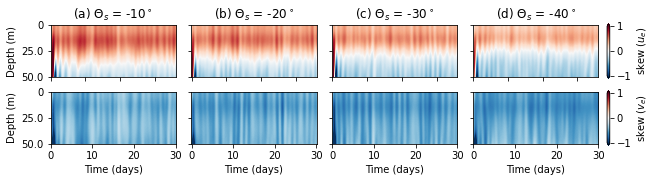

In [19]:
# Skewness of Ekman current
hmax = 50.
iz = np.argmin(abs(z + hmax))
xt = np.arange(0,len(t),len(t)//3)
xtl = t[xt].astype(int)
yt = [0,len(z[:iz])//2,len(z[:iz])]
ytl = [0,hmax/2,hmax]
vmin, vmax = -1, 1
ticks = np.linspace(vmin, vmax, 3, endpoint=True)
tit = []
for m in range(nm):
    tit.append(f'({int_to_lt(m)}) {labels[m]}')

fig, ax = plt.subplots(2,len(ds),constrained_layout=True,figsize=(9,2.4))
for m in range(nm):
    #im = ax[0,m].imshow(ds[m].variables['u_skew'][:,:iz].data.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['u_skew'][:,:iz].data, axis=0)
    im = ax[0,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[0,m].set(title=tit[m], xticklabels=[])
    if m > 0:
        ax[0,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[0,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')    
cb = plt.colorbar(im, ax=ax[0,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('skew ($u_e$)')

for m in range(nm):
    #im = ax[1,m].imshow(ds[m].variables['v_skew'][:,:iz].data.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['v_skew'][:,:iz].data, axis=0)
    im = ax[1,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[1,m].set(xlabel='Time (days)', xticks=xt, xticklabels=xtl)  
    if m > 0:
        ax[1,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[1,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')     
cb = plt.colorbar(im, ax=ax[1,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('skew ($v_e$)')

output = os.path.join(outdir,'uv_skew_thetas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

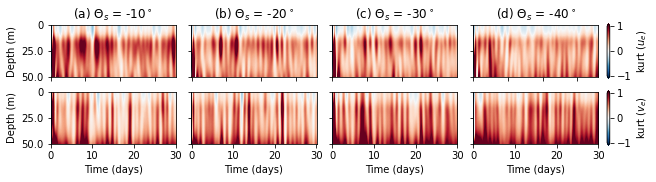

In [20]:
# Kurtosis of Ekman current
fig, ax = plt.subplots(2,len(ds),constrained_layout=True,figsize=(9,2.4))
for m in range(nm):
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['u_kurt'][:,:iz].data, axis=0)
    im = ax[0,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[0,m].set(title=tit[m], xticklabels=[])
    if m > 0:
        ax[0,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[0,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')    
cb = plt.colorbar(im, ax=ax[0,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('kurt ($u_e$)')

for m in range(nm):
    f = signal.filtfilt(num_filt, denom_filt, ds[m].variables['v_kurt'][:,:iz].data, axis=0)
    im = ax[1,m].imshow(f.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)    
    ax[1,m].set(xlabel='Time (days)', xticks=xt, xticklabels=xtl)  
    if m > 0:
        ax[1,m].set(yticks=yt, yticklabels=[]) 
    else: 
        ax[1,m].set(yticks=yt, yticklabels=ytl, ylabel='Depth (m)')     
cb = plt.colorbar(im, ax=ax[1,-1], ticks=ticks, extend='both', fraction=0.025, pad=0.02) 
cb.set_label('kurt ($v_e$)')

output = os.path.join(outdir,'uv_kurt_thetas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

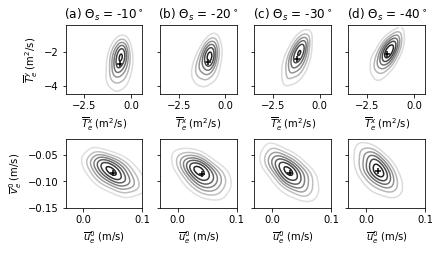

In [21]:
# Plot PDFs of Ekman transport and surface current
fig, ax = plt.subplots(2,nm,sharex='row',sharey='row',constrained_layout=True,figsize=(6,3.4))
xmin, ymin, lxy = -3.5, -4.5, 4.1
xl_T, yl_T = [xmin,xmin+lxy], [ymin,ymin+lxy]
xmin, ymin, lxy = -0.03, -0.15, 0.13
xl_u0, yl_u0 = [xmin,xmin+lxy], [ymin,ymin+lxy]

for m in range(nm):
    U = ds[m].variables['Tx_tmean'][:].data + 1j*ds[m].variables['Ty_tmean'][:].data
    X, Y, Z = kde_pdf(U)
    ax[0,m].contour(X, Y, Z, cmap='binary')
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[0,m].scatter(Xm, Ym, marker='+', c='k')
    ax[0,m].set(title=tit[m], xlabel='$\overline{T}_e^x$ (m$^2$/s)', xlim=xl_T, ylim=yl_T)
    
    U = ds[m].variables['u0_tmean'][:].data + 1j*ds[m].variables['v0_tmean'][:].data
    X, Y, Z = kde_pdf(U)
    ax[1,m].contour(X, Y, Z, cmap='binary')
    Xm, Ym = U.real.mean(), U.imag.mean()
    ax[1,m].scatter(Xm, Ym, marker='+', c='k')    
    ax[1,m].set(xlabel='$\overline{u}_e^0$ (m/s)', xlim=xl_u0, ylim=yl_u0)    
ax[0,0].set_ylabel('$\overline{T}_e^y$ (m$^2$/s)')  
ax[1,0].set_ylabel('$\overline{v}_e^0$ (m/s)')   

output = os.path.join(outdir,'pdf_thetas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

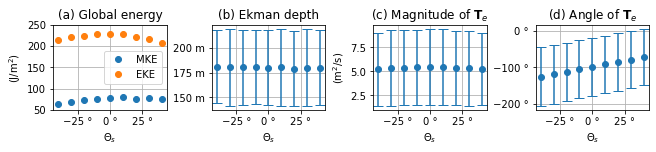

In [22]:
# Scatter plot
nm = 9
theta_mean = np.linspace(-40,40,nm)
ds = []
for m in range(nm):
    ncfile = os.path.join(dirm,f'ua{ua_std:.1f}_us{us0:.3f}_hs{hs:.3f}_ts{int(theta_mean[m])}','diag.nc')
    ds.append(Dataset(ncfile,'r')) 
    
mke, eke = [], []
h_mean, h_std = [], []
T_mean, T_std = [], []
arg_mean, arg_std = [], []
Tx_skew, Ty_skew, Tx_kurt, Ty_kurt = [], [], [], []
for m in range(nm):
    mke.append(np.mean(ds[m].variables['mke'][id0:].data))
    eke.append(np.mean(ds[m].variables['eke'][id0:].data))
    
    h_mean.append(np.mean(ds[m].variables['h_mean'][id0:].data))
    h_std.append(np.mean(ds[m].variables['h_std'][id0:].data))
    
    Tm = np.mean(ds[m].variables['absT_mean'][id0:].data)
    Ts = np.mean(ds[m].variables['absT_std'][id0:].data)
    #T = ds[m].variables['Tx_tmean'][:].data + 1j*ds[m].variables['Ty_tmean'][:].data
    #Tm, Ts = np.mean(abs(T)), np.std(abs(T))
    T_mean.append(Tm)
    T_std.append(Ts)
    
    argm = stats.circmean(ds[m].variables['argT_mean'][id0:].data) - 2*np.pi
    args = stats.circmean(ds[m].variables['argT_std'][id0:].data)
    #arg = np.angle(T)
    #argm, args = stats.circmean(arg)-2*np.pi, stats.circstd(arg)
    arg_mean.append(np.rad2deg(argm))
    arg_std.append(np.rad2deg(args))

    #Tx_skew.append(stats.skew(T.real))
    #Ty_skew.append(stats.skew(T.imag))
    #Tx_kurt.append(stats.kurtosis(T.real))
    #Ty_kurt.append(stats.kurtosis(T.imag))
    
fig, ax = plt.subplots(1,4,constrained_layout=True,figsize=(9,2))    
ax[0].errorbar(theta_mean, mke, fmt='o', label='MKE') 
ax[0].errorbar(theta_mean, eke, fmt='o', label='EKE') 
ax[0].set(xlabel=r'$\Theta_s$', ylabel='(J/m$^2$)', title='(a) Global energy', ylim=[50,250])
ax[0].xaxis.set_major_formatter(EngFormatter(unit=u"°"))
ax[0].legend()
ax[0].grid()    
    
ax[1].errorbar(theta_mean, h_mean, h_std, fmt='o', capsize=5)    
ax[1].set(xlabel=r'$\Theta_s$', title='(b) Ekman depth')
ax[1].yaxis.set_major_formatter(EngFormatter(unit=u"m"))
#ax[1].errorbar(theta_mean, Tx_skew, fmt='o', label='$\overline{T}_x$') 
#ax[1].errorbar(theta_mean, Ty_skew, fmt='o', label='$\overline{T}_y$') 
#ax[1].set(xlabel=r'$\Theta_s$', title='(b) Skew of $\overline{\mathbf{T}}$', ylim=[-1,1])
#ax[1].legend()
ax[1].xaxis.set_major_formatter(EngFormatter(unit=u"°"))
ax[1].grid()    

ax[2].errorbar(theta_mean, T_mean, T_std, fmt='o', capsize=5)    
ax[2].set(xlabel=r'$\Theta_s$', ylabel='(m$^2$/s)', title='(c) Magnitude of $\mathbf{T}_e$')
ax[2].xaxis.set_major_formatter(EngFormatter(unit=u"°"))
ax[2].grid()

ax[3].errorbar(theta_mean, arg_mean, arg_std, fmt='o', capsize=5)    
ax[3].set(xlabel=r'$\Theta_s$', title='(d) Angle of $\mathbf{T}_e$')
ax[3].xaxis.set_major_formatter(EngFormatter(unit=u"°"))
ax[3].yaxis.set_major_formatter(EngFormatter(unit=u"°"))
ax[3].grid()  

output = os.path.join(outdir,'errbar_thetas.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

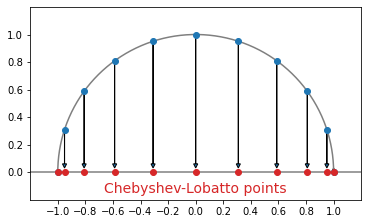

In [23]:
# Illustration for Chebyshev nodes
n = 10

# Calculate θₙ
θₙ = np.pi * (2 * np.arange(1, n+1) - 1) / (2 * n)
θₙ = np.pi * np.arange(n+1) / (n)

# Generate θ
θ = np.linspace(0, np.pi, 300)

# Plot unit circle
plt.figure(constrained_layout=True, figsize=(5,3))
plt.plot(np.cos(θ), np.sin(θ), c=colors[7])

# Plot x-axis
plt.plot([-1.2, 1.2], [0, 0], c=colors[7])

# Plot Chebyshev nodes
plt.plot(np.cos(θₙ), np.sin(θₙ), 'o')
plt.plot(np.cos(θₙ), np.zeros_like(θₙ), 'o', c=colors[3])
plt.text(0, -0.15, "Chebyshev-Lobatto points", horizontalalignment="center", color=colors[3], fontsize=14)

# Add arrows
for k in range(n):
    x, y = np.cos(θₙ[k]), np.sin(θₙ[k])
    plt.arrow(x, y, 0, -y + 0.03, head_width=0.03, head_length=0.03, length_includes_head=True)

# Customize axes
plt.xticks(np.arange(-1, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.axis("equal")
plt.xlim(-1.2, 1.2)

output = os.path.join(outdir,'chebnodes.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)

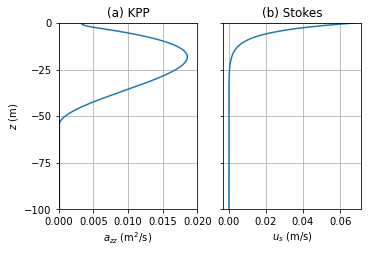

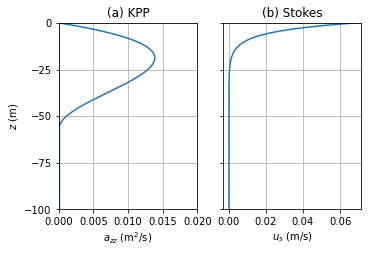

In [24]:
# Illustration of parameterizations
param = {
        'ne': 1, # number of ensemble samples
        'nz': 512, # number of vertical levels (T-grid)    
        'H': 256., # finite depth (m) 
        'dt': 1800., # time step (s)
        'f': 0.73e-4, # Coriolis parameter (s^-1)
        'rhooc': 1.0e3, # water density (kg/m^3)
        'rhoat': 1., # air density (kg/m^3)
        'Cd': 1.3e-3, # air-sea drag coef.
        'c1': 0.4, # von Karman constant
        'c2': 0.7, # constant to determine spde.n layer thickness
        'z0': 0.05, # constant to regularize log singularity
        'rand_wind': False, # option to include random wind fluctuations
        'ua_mean': 5.+0.j, # mean wind speed (m/s)
        'ua_std': 5., # std of wind speed (m/s)
        'Ta': 86400., # memory time for wind fluc. (s)
        'rand_wave': False, # option to include random wave angles
        'us0': 0.068, # Stokes amplititude (m/s)
        'hs': 4.775, # Stokes thickness (m)
        'theta_mean': 0*np.pi/180, # mean of Stokes angular direction
        'theta_std': 0*np.pi/180, # std of Stokes angular direction
        'wave_sbc': False, # include wave stress to surface BC
        'r': 0., # damping rate due to radiation of internal waves (s^-1)
        'kappa': 1.0e-4, # background uniform viscosity (m^2/s) 
        'rand_model': True, # option to use stochastic dynamical model
        'full_model': True, # option to include vertical mixing of waves 
        'device': 'cpu', #if torch.cuda.is_available() else 'cpu',
}
spde = SGESM1d(param)
z = spde.z.squeeze().numpy()
a = spde.a.squeeze().numpy()
u = spde.us.real.squeeze().numpy()

fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(5,3.4))
ax[0].plot(a[::-1], z[::-1])
ylim = [-100.,0.]
yt = np.linspace(ylim[0],ylim[1],5,endpoint=True)
ax[0].set(title='(a) KPP', xlabel='$a_{zz}$ (m$^2$/s)', ylabel='$z$ (m)', ylim=ylim, yticks=yt, xlim=(0,0.02))
ax[0].grid()
ax[1].plot(u[::-1], z[::-1])
ax[1].set(title='(b) Stokes', xlabel='$u_s$ (m/s)')
ax[1].grid()
output = os.path.join(outdir,'kpp_stokes.pdf')
plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0)